In [1]:
import numpy as np
import gzip
import pickle
import sys
import copy
import os.path
import pdb
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Split MNIST

In [5]:
with open('results/split_mnist.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc = d['vcl_ibp']
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


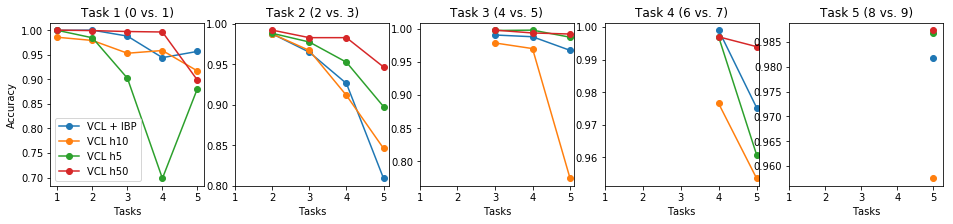

In [12]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


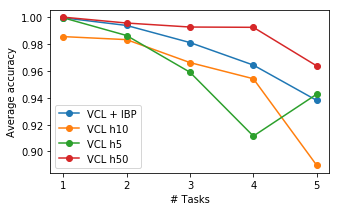

In [15]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Not MNIST

In [19]:
with open('results/not_mnist.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc = d['vcl_ibp']
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


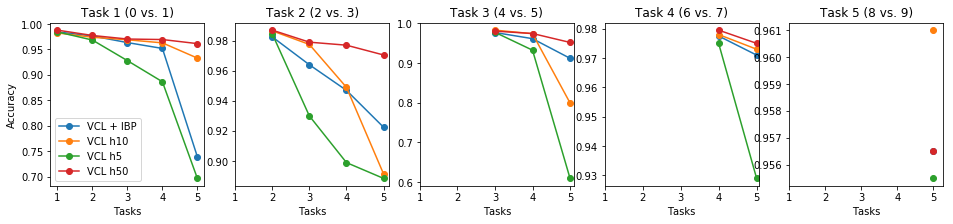

In [20]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


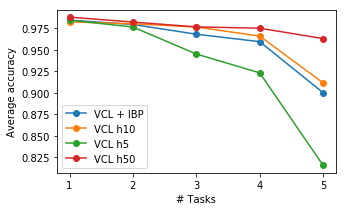

In [21]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Split results av and BO opt params

In [57]:
with open('ddm/results/split_mnist_res5_vanilla.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc = d['vcl_ibp']
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']

In [58]:
with open('results/split_mnist_res5_opt_params.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc_opt = d['vcl_ibp']
vcl_result_opt = d['vcl_h10']
vcl_result_h5_opt = d['vcl_h5']
vcl_result_h50_opt = d['vcl_h50']

In [59]:
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
_ibp_acc_opt = np.mean(ibp_acc_opt, 0)
_vcl_result_opt = np.mean(vcl_result_opt, 0)
_vcl_result_h5_opt = np.mean(vcl_result_h5_opt, 0)
_vcl_result_h50_opt = np.mean(vcl_result_h50_opt, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


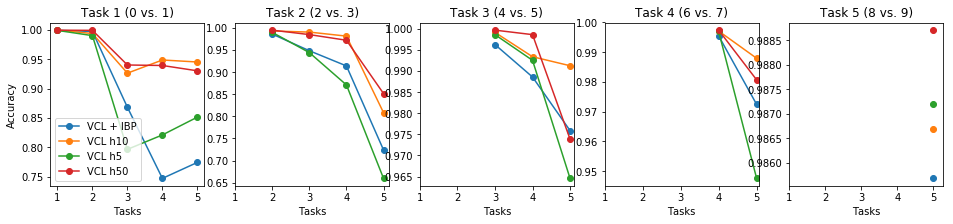

In [60]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


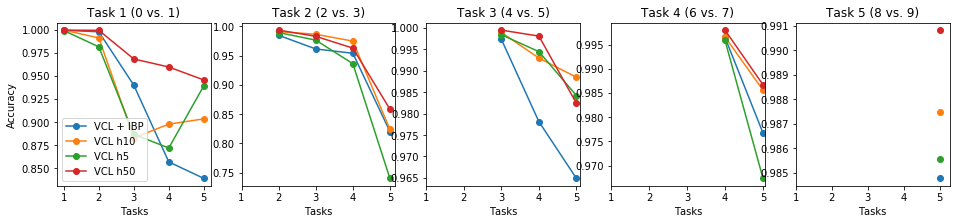

In [62]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc_opt[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result_opt[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5_opt[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50_opt[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


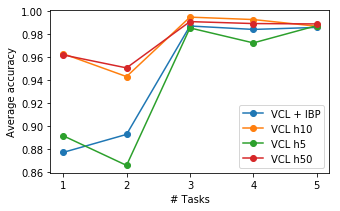

In [34]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


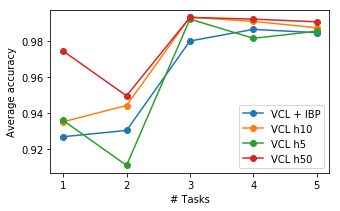

In [63]:
_ibp_acc_opt = np.nanmean(ibp_acc_opt, (0,1))
_vcl_result_opt = np.nanmean(vcl_result_opt, (0,1))
_vcl_result_h5_opt = np.nanmean(vcl_result_h5_opt, (0,1))
_vcl_result_h50_opt = np.nanmean(vcl_result_h50_opt, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc_opt, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_opt, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5_opt, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50_opt, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Beta trick split MNIST

In [36]:
with open('results/res_beta_trick_split.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
ibp_acc = d['vcl_ibp']
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']

In [37]:
ibp_acc.shape

(5, 5)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


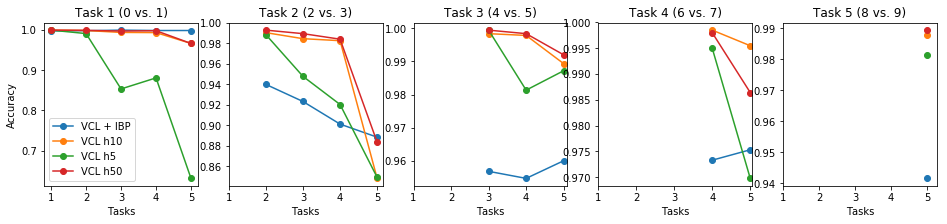

In [39]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


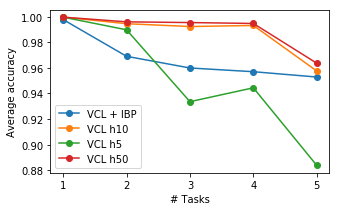

In [40]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Not results av and opt params

In [73]:
with open('results/split_not_mnist_res5.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [74]:
with open('results/split_not_mnist_res5_opt_params.pkl', 'rb') as input_file:
    d_opt = pickle.load(input_file)
d_opt.keys()

FileNotFoundError: [Errno 2] No such file or directory: 'results/split_not_mnist_res5_opt_params.pkl'

In [75]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
# ibp_acc_opt = d_opt['vcl_ibp'] # 5, 5, 5
# vcl_result_opt = d_opt['vcl_h10']
# vcl_result_h5_opt = d_opt['vcl_h5']
# vcl_result_h50_opt = d_opt['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0, 1))
__vcl_result = np.nanmean(vcl_result, (0, 1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0, 1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0, 1))
# _ibp_acc_opt = np.mean(ibp_acc_opt, 0)
# _vcl_result_opt = np.mean(vcl_result_opt, 0)
# _vcl_result_h5_opt = np.mean(vcl_result_h5_opt, 0)
# _vcl_result_h50_opt = np.mean(vcl_result_h50_opt, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


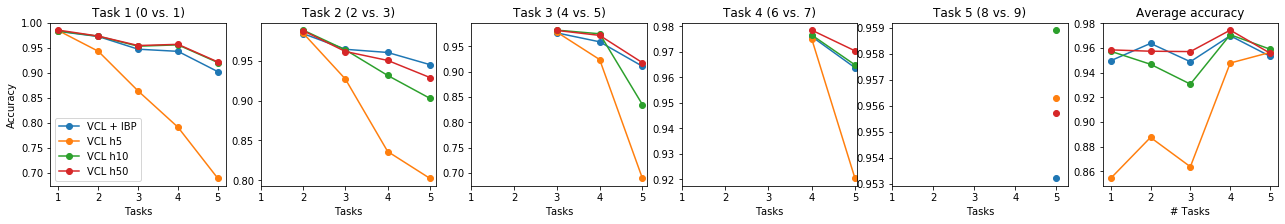

In [76]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o')
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy')
ax[5].set_xlabel('# Tasks')
fig.savefig('plots/split_not_all.pdf', bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


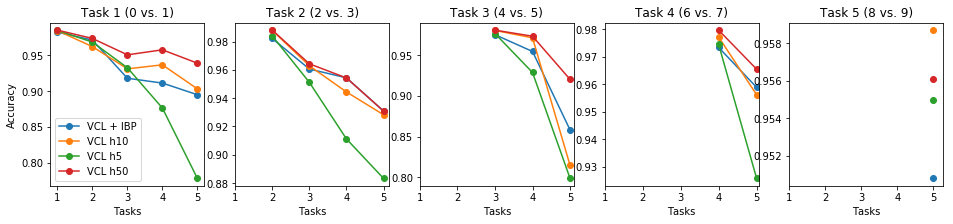

In [70]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc_opt[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5_opt[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result_opt[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50_opt[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
        
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


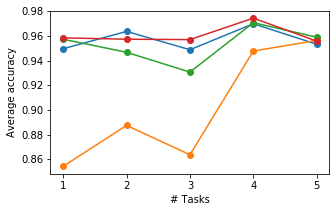

In [77]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
#ax.legend()
fig.savefig('plots/split_not.pdf', bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


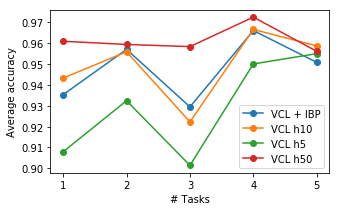

In [72]:
_ibp_acc_opt = np.nanmean(ibp_acc_opt, (0,1))
_vcl_result_opt = np.nanmean(vcl_result_opt, (0,1))
_vcl_result_h5_opt = np.nanmean(vcl_result_h5_opt, (0,1))
_vcl_result_h50_opt = np.nanmean(vcl_result_h50_opt, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc_opt, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_opt, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5_opt, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50_opt, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# Difficult split MNIST 5 runs and opt params

In [43]:
with open('ddm/results/split_mnist_res5_difficult.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [48]:
with open('results/split_mnist_res5_difficult_opt_params.pkl', 'rb') as input_file:
    d_opt = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [49]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
ibp_acc_opt = d_opt['vcl_ibp'] # 5, 5, 5
vcl_result_opt = d_opt['vcl_h10']
vcl_result_h5_opt = d_opt['vcl_h5']
vcl_result_h50_opt = d_opt['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
_ibp_acc_opt = np.mean(ibp_acc_opt, 0)
_vcl_result_opt = np.mean(vcl_result_opt, 0)
_vcl_result_h5_opt = np.mean(vcl_result_h5_opt, 0)
_vcl_result_h50_opt = np.mean(vcl_result_h50_opt, 0)

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


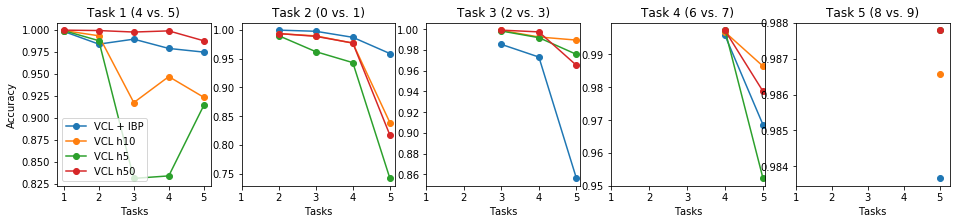

In [50]:
titles = {0: "Task 1 (4 vs. 5)",
          1: "Task 2 (0 vs. 1)",
          2: "Task 3 (2 vs. 3)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


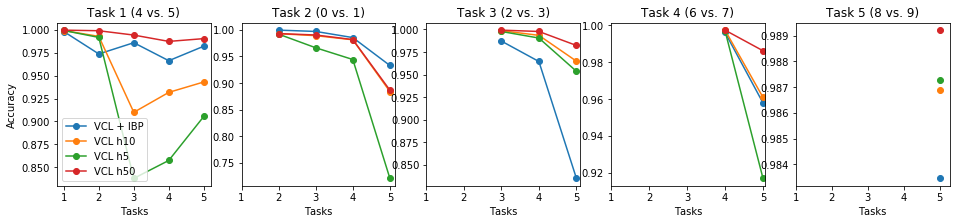

In [51]:
titles = {0: "Task 1 (4 vs. 5)",
          1: "Task 2 (0 vs. 1)",
          2: "Task 3 (2 vs. 3)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc_opt[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result_opt[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5_opt[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50_opt[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


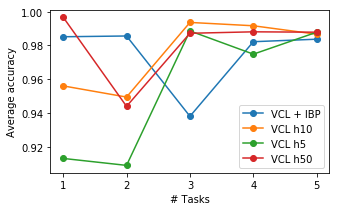

In [52]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


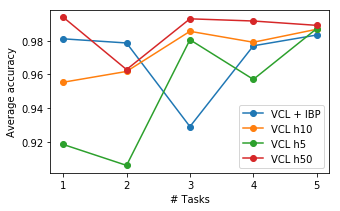

In [53]:
_ibp_acc_opt = np.nanmean(ibp_acc_opt, (0,1))
_vcl_result_opt = np.nanmean(vcl_result_opt, (0,1))
_vcl_result_h5_opt = np.nanmean(vcl_result_h5_opt, (0,1))
_vcl_result_h50_opt = np.nanmean(vcl_result_h50_opt, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc_opt, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_opt, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5_opt, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50_opt, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
fig.show()

# New results Normal MNIST

In [47]:
with open('results/split_mnist_res5_split_normal.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [48]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


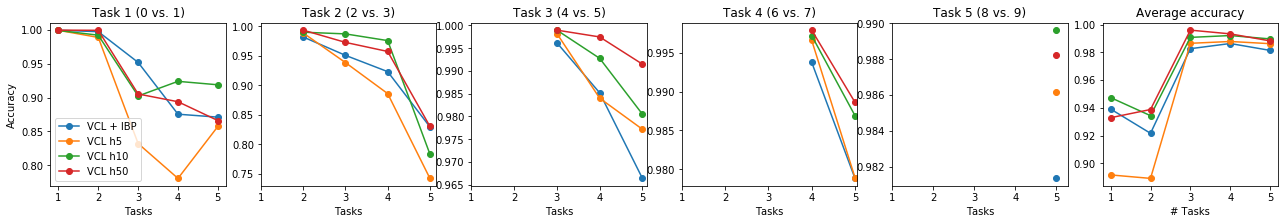

In [49]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o')
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o')
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy')
ax[5].set_xlabel('# Tasks')
#ax[5].legend()
plt.savefig("plots/split_normal_all.pdf", bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


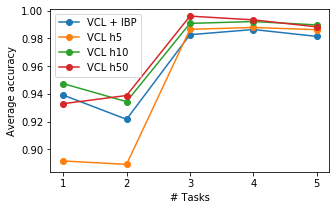

In [50]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
ax.legend()
plt.savefig("plots/split_normal.pdf", bbox_inches='tight')
fig.show()

# Random background noise MNIST

In [63]:
with open('results/split_mnist_res5_split_random.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [64]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


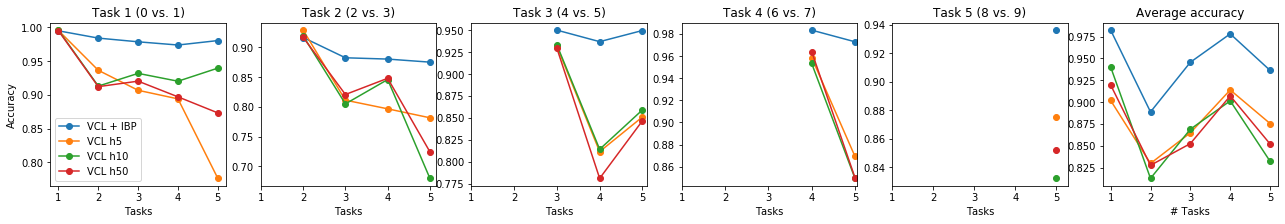

In [65]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o')
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o')
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy')
ax[5].set_xlabel('# Tasks')
#ax[5].legend()
plt.savefig("plots/rand_background_noise_all.pdf", bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


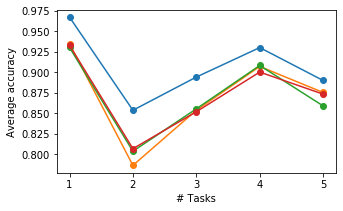

In [71]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
#ax.legend()
plt.savefig("plots/rand_background_noise.pdf", bbox_inches='tight')
fig.show()

# Background images MNIST

In [68]:
#split_mnist_res5_split_background.pkl
with open('results/split_mnist_res5_split_background.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50'])

In [69]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


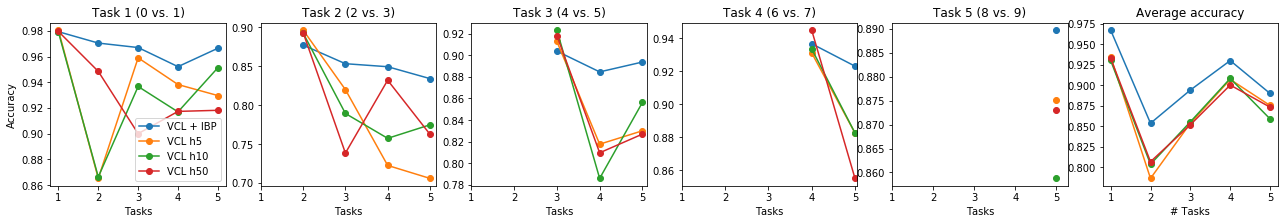

In [70]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o')
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o')
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy')
ax[5].set_xlabel('# Tasks')
#ax[5].legend()
plt.savefig("plots/image_background_noise_all.pdf", bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


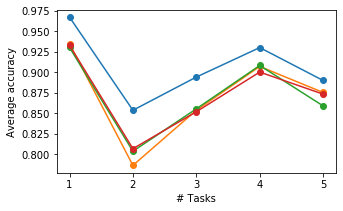

In [72]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
#ax.legend()
plt.savefig("plots/image_background_noise.pdf", bbox_inches='tight')
fig.show()

# Not MNIST

In [3]:
#split_mnist_res5_split_background.pkl
with open('../results/split_not_mnist_res5_split_not_new.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['vcl_ibp', 'vcl_h10', 'vcl_h5', 'vcl_h50', 'Z'])

In [4]:
ibp_acc = d['vcl_ibp'] # 5, 5, 5
vcl_result = d['vcl_h10']
vcl_result_h5 = d['vcl_h5']
vcl_result_h50 = d['vcl_h50']
_ibp_acc = np.mean(ibp_acc, 0)
_vcl_result = np.mean(vcl_result, 0)
_vcl_result_h5 = np.mean(vcl_result_h5, 0)
_vcl_result_h50 = np.mean(vcl_result_h50, 0)
__ibp_acc = np.nanmean(ibp_acc, (0,1))
__vcl_result = np.nanmean(vcl_result, (0,1))
__vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
__vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


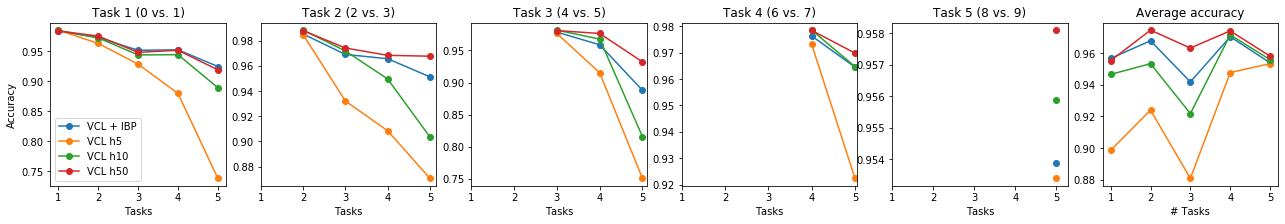

In [5]:
titles = {0: "Task 1 (0 vs. 1)",
          1: "Task 2 (2 vs. 3)",
          2: "Task 3 (4 vs. 5)",
          3: "Task 4 (6 vs. 7)",
          4: "Task 5 (8 vs. 9)"}
no_tasks=5
fig, ax = plt.subplots(1, 6, figsize=(22, 3))
for i in range(no_tasks):
    ax[i].plot(np.arange(len(ibp_acc[:, i]))+1, _ibp_acc[:, i], label='VCL + IBP', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h5[:, i]))+1, _vcl_result_h5[:, i], label='VCL h5', marker='o')
    ax[i].plot(np.arange(len(vcl_result[:, i]))+1, _vcl_result[:, i], label='VCL h10', marker='o')
    ax[i].plot(np.arange(len(vcl_result_h50[:, i]))+1, _vcl_result_h50[:, i], label='VCL h50', marker='o')
    ax[i].set_title(titles[i])
    ax[i].set_xticks(range(1, len(vcl_result[:,i])+1))
    ax[i].set_xlabel('Tasks')
    if i == 0:
        ax[i].legend()
        ax[i].set_ylabel('Accuracy')
        
ax[5].plot(np.arange(len(__ibp_acc))+1, __ibp_acc, label='VCL + IBP', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result_h5, label='VCL h5', marker='o')
ax[5].plot(np.arange(len(__vcl_result))+1, __vcl_result, label='VCL h10', marker='o')
ax[5].plot(np.arange(len(_vcl_result))+1, __vcl_result_h50, label='VCL h50', marker='o')
ax[5].set_xticks(range(1, len(_ibp_acc)+1))
ax[5].set_title('Average accuracy')
ax[5].set_xlabel('# Tasks')
#ax[5].legend()
plt.savefig("plots/not_all_accs.pdf", bbox_inches='tight')
fig.show()

/Users/samuelKessler/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


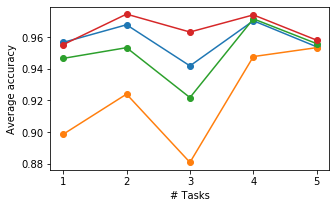

In [6]:
_ibp_acc = np.nanmean(ibp_acc, (0,1))
_vcl_result = np.nanmean(vcl_result, (0,1))
_vcl_result_h5 = np.nanmean(vcl_result_h5, (0,1))
_vcl_result_h50 = np.nanmean(vcl_result_h50, (0,1))

fig = plt.figure(figsize=(5,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('# Tasks')
#ax.legend()
plt.savefig("plots/not_av_acc.pdf", bbox_inches='tight')
fig.show()

# Z histograms

In [14]:
from run_split import SplitMnistGenerator, SplitMnistRandomGenerator, SplitMnistBackgroundGenerator
from alg.cla_models_multihead import MFVI_IBP_NN, Vanilla_NN
import tensorflow as tf

In [52]:
dataset='random' #'normal' # background, random
tag='split_random_new' # split_normal_new split_background_new, split_random_new
val = False
def get_datagen():
    if dataset == 'normal':
        data_gen = SplitMnistGenerator(val=val, difficult=False)
    elif dataset == 'random':
        data_gen = SplitMnistRandomGenerator(val=val)
    elif dataset == 'background':
        data_gen = SplitMnistBackgroundGenerator(val=val)
    else:
        raise ValueError('Pick dataset in {normal, random, background}')
    return data_gen

############
## Params ##
############
data_gen = get_datagen()
in_dim, out_dim = data_gen.get_dims()
alpha0 = 5.0
beta0 = 1.0
lambda_1 = 1.0
lambda_2 = 1.0
hidden_size = [100]
bsize = 256
no_epochs = 1000
ibp_samples = 10
coreset_size = 0
single_head = False
in_dim = 28 * 28
out_dim = 2
run=0
name='ibp_split_mnist_{2}_run{0}_{1}'.format(run+1, tag, dataset)

################################################
## Restore model for each task and get test Z ##
################################################
Zs = []
x_testsets, y_testsets = [], []
for task_id in range(data_gen.max_iter):
    tf.reset_default_graph()
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 100, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    x_train, y_train, x_test, y_test = data_gen.next_task()
    #x_testsets.append(x_test)
    #y_testsets.append(y_test)
    
    name='ibp_split_mnist_{2}_run{0}_{1}'.format(run+1, tag, dataset)
    log_folder = os.path.join('logs', "graph_{}_task{}".format(name, task_id))
    mf_model = MFVI_IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=None,
                           prev_log_variances=None, prev_betas=None,
                           alpha0=alpha0, beta0=beta0, learning_rate=0.0001,
                           lambda_1=lambda_1,
                           lambda_2=lambda_2 if task_id == 0 else lambda_1,
                           no_pred_samples=100,
                           name=name)
    mf_model.restore(log_folder)
    
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()
    
    Zs.append(mf_model.sess.run(mf_model.Z, feed_dict={mf_model.x: x_test,
                                                       mf_model.task_idx: task_id,
                                                       mf_model.training: False, mf_model.temp: 1.0})[0])

    mf_model.close_session()

Epoch: 0001 cost= 0.564025915
Epoch: 0006 cost= 0.226696945
Epoch: 0011 cost= 0.207671461
Epoch: 0016 cost= 0.189814422
Epoch: 0021 cost= 0.179338605
Epoch: 0026 cost= 0.167590513
Epoch: 0031 cost= 0.154772354
Epoch: 0036 cost= 0.142664715
Epoch: 0041 cost= 0.132126192
Epoch: 0046 cost= 0.132778985
Epoch: 0051 cost= 0.128707070
Epoch: 0056 cost= 0.111729354
Epoch: 0061 cost= 0.094212960
Epoch: 0066 cost= 0.091561809
Epoch: 0071 cost= 0.081361189
Epoch: 0076 cost= 0.076409434
Epoch: 0081 cost= 0.070504178
Epoch: 0086 cost= 0.063330679
Epoch: 0091 cost= 0.061599487
Epoch: 0096 cost= 0.065871076
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_ibp_split_mnist_random_run1_split_random_new_task0/model.ckpt
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)
INFO:tensorflow:Restoring parameters from logs/graph_ibp_split_mnist_random_run1_split_random_new_task1/model.ckpt
(1, ?,

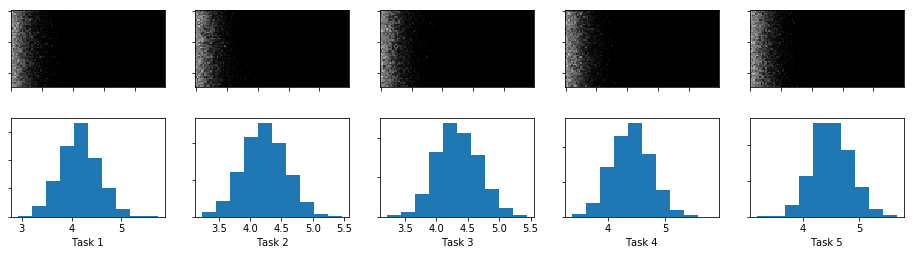

In [53]:
num_tasks = 5
fig, ax = plt.subplots(2, num_tasks, figsize=(16, 4))
for i in range(num_tasks):
    ax[0][i].imshow(np.squeeze(Zs[i])[:50,:], cmap=plt.cm.Greys_r, vmin=0, vmax=1)
    ax[0][i].set_xticklabels([])
    ax[0][i].set_yticklabels([])
    ax[1][i].hist(np.sum(np.squeeze(Zs[i]), axis=1), 10)
    ax[1][i].set_yticklabels([])
    ax[1][i].set_xlabel("Task {}".format(i+1))
    #cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    #fig.colorbar(imgplot, cax=cbar_ax)
    plt.savefig('plots/Zs_{0}.pdf'.format(tag), bbox_inches='tight')
    fig.show()

In [48]:
print(tag)
[np.mean(Zs[i]) for i in range(num_tasks)]

split_normal_new


[0.04128668, 0.04197896, 0.042803187, 0.043181498, 0.0439923]

In [51]:
print(tag)
[np.mean(Zs[i]) for i in range(num_tasks)]

split_background_new


[0.041683517, 0.042332184, 0.043382287, 0.044187617, 0.044862676]

In [54]:
print(tag)
[np.mean(Zs[i]) for i in range(num_tasks)]

split_random_new


[0.041582633, 0.042348202, 0.04341242, 0.044086292, 0.04496457]